In [1]:
import numpy as np 
import pandas as pd
import os, pdb
import pixiedust
import cv2
# visualization
import matplotlib.pyplot as plt
from matplotlib import patches as patches
# plotly offline imports
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import subplots
import plotly.express as px
import plotly.figure_factory as ff
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis

def rle_to_mask(rle_string, height, width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

def bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax


def plot_cloud(img_path, img_id, label_mask):
    img = cv2.imread(os.path.join(img_path, img_id))
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
    ax[0].imshow(img)
    ax[1].imshow(img)
    cmaps = {'Fish': 'Blues', 'Flower': 'Reds', 'Gravel': 'Greys', 'Sugar':'Purples'}
    colors = {'Fish': 'Blue', 'Flower': 'Red', 'Gravel': 'Gray', 'Sugar':'Purple'}
    for label, mask in label_mask:
        mask_decoded = rle_to_mask(mask, img.shape[0], img.shape[1])
        if mask != -1:
            rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
            bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor=colors[label],facecolor='none')
            ax[0].add_patch(bbox)
            ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=colors[label]))
            ax[1].imshow(mask_decoded, alpha=0.3, cmap=cmaps[label])
            ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=colors[label]))

data_dir = 'C:/Users/hmnsh/repos/datastuff/kaggle/cloud2019/'
train_image_path = os.path.join(data_dir, 'clouds_resized/train_images_525')
#test_image_dir = os.path.join(ship_dir, 'test_v2')
#Get target label and image name in separate column
train_df = pd.read_csv(f"{data_dir}/train.csv").fillna(-1)
# image id and class id are two seperate entities and it makes it easier to split them up in two columns
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['Label'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['Label_EncodedPixels'] = train_df.apply(lambda row: (row['Label'], row['EncodedPixels']), axis = 1)


# lets group each of the types and their mask in a list so we can do more aggregated counts
grouped_EncodedPixels = train_df.groupby('ImageId')['Label_EncodedPixels'].apply(list)

Pixiedust database opened successfully


In [2]:
grouped_EncodedPixels.isnull().sum()

0

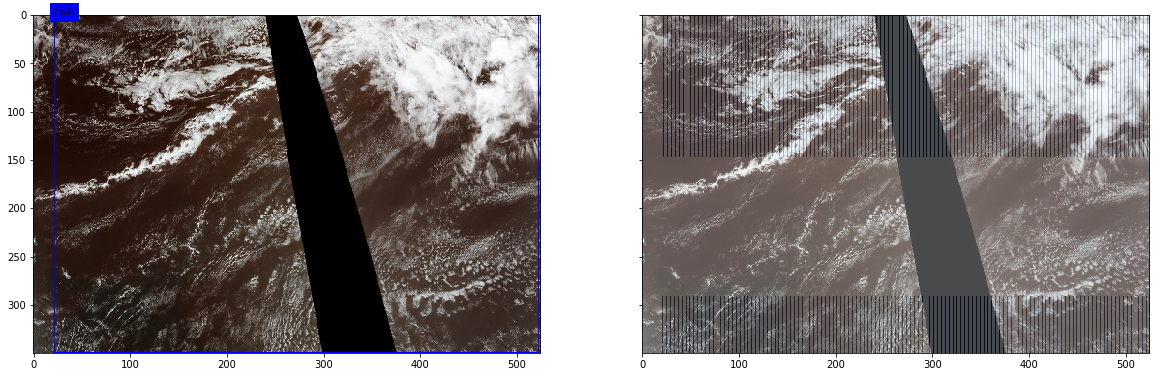

In [3]:
%%pixie_debugger
for image_id, label_mask in grouped_EncodedPixels.sample(10).iteritems():
    plot_cloud(train_image_path, image_id, label_mask)